---
title: stata教程03-异方差的检验和处理
date: 2018-12-11 19:17:55
tags: [stata]
toc: true
mathjax: true

---

古典线性回归的假设是一种理想状态, 现实数据很难满足, 比如异方差就是一个常见的违背模型假设的情况。下面我们介绍一下如何检验数据是否存在异方差以及出现异方差的情况后如何处理。
<span></span>
<!-- more -->

### 数据介绍

这是Nevlove(1963)的数据, 在之前的教程中一直使用这个数据, 相信大家已经非常熟悉。首先我们载入数据集:

In [1]:
use data/nerlove.dta, clear

(Nerlove 1963 paper)


看一下数据的基本情况:

In [2]:
describe


Contains data from data/nerlove.dta
  obs:           145                          Nerlove 1963 paper
 vars:            10                          13 Aug 2012 10:00
 size:         5,220                          
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
tc              float   %9.0g                 total cost
q               int     %8.0g                 total output
pl              float   %9.0g                 price of la

做简单的线性回归:

In [3]:
reg lntc lnq lnpl lnpk lnpf


      Source |       SS           df       MS      Number of obs   =       145
-------------+----------------------------------   F(4, 140)       =    437.90
       Model |  269.524728         4  67.3811819   Prob > F        =    0.0000
    Residual |  21.5420958       140  .153872113   R-squared       =    0.9260
-------------+----------------------------------   Adj R-squared   =    0.9239
       Total |  291.066823       144  2.02129738   Root MSE        =    .39227

------------------------------------------------------------------------------
        lntc |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         lnq |   .7209135   .0174337    41.35   0.000     .6864462    .7553808
        lnpl |   .4559645    .299802     1.52   0.131    -.1367602    1.048689
        lnpk |  -.2151476   .3398295    -0.63   0.528    -.8870089    .4567136
        lnpf |   .4258137   .1003218     4.24   0.

画残差与拟合值的散点图:

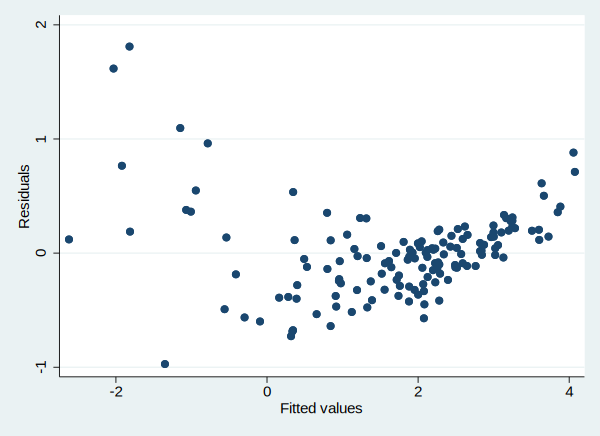

In [4]:
rvfplot

从这个图中可以清楚的看到, 随着拟合值的变化, 残差也发生了有规律的变化。所以我们可以怀疑存在异方差的现象。

我们还可以绘制残差与任意变量的散点图:

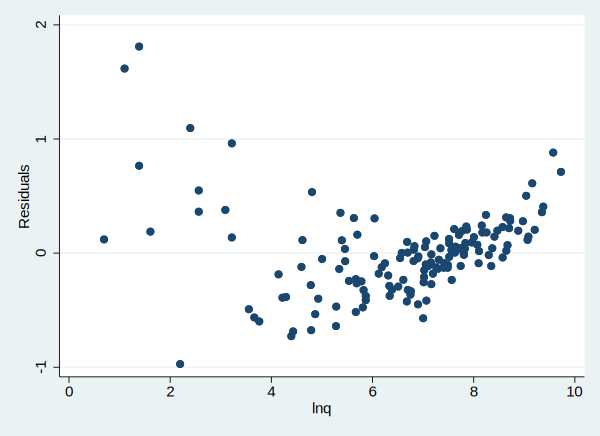

In [6]:
rvpplot lnq

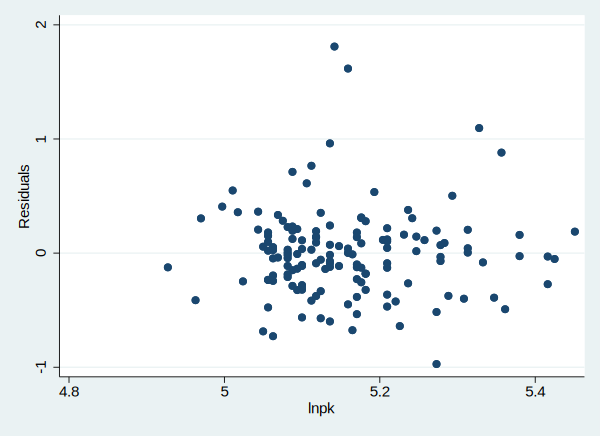

In [8]:
rvpplot lnpk

上面的散点图可以看出, 很有可能存在异方差的现象。

### 怀特检验

我们可以使用怀特检验来检验异方差是否真的存在。我们用到了`estat`命令, 它指的是'post-estimation statistics', 统计后估计量, 而imtest指的是informatrix test:

In [9]:
estat imtest, white


White's test for Ho: homoskedasticity
         against Ha: unrestricted heteroskedasticity

         chi2(14)     =     73.88
         Prob > chi2  =    0.0000

Cameron & Trivedi's decomposition of IM-test

---------------------------------------------------
              Source |       chi2     df      p
---------------------+-----------------------------
  Heteroskedasticity |      73.88     14    0.0000
            Skewness |      22.79      4    0.0001
            Kurtosis |       2.62      1    0.1055
---------------------+-----------------------------
               Total |      99.29     19    0.0000
---------------------------------------------------


我们可以看到卡方值是`chi2(14) = 73.88`, 显著性为 `Prob > chi2  = 0.0000`, 显然应当拒绝虚无假设Ho: homoskedasticity, 存在异方差。

### BP检验

我们还可以使用BP检验:

stata实际应用中, 我们可能采取三种方法, 通常这三种方法都可以做一遍:

- estate hettest (默认设置, 使用拟合值$\hat y$
- estat hettest, rhs (使用方程右边的解释变量)
- estat hettest [varlilst] (使用指定模型解释变量)

同时, 我们需要假设扰动项满足独立同分布(iid)假设。如果不使用iid参数, 则假设扰动项服从正太分布。

下面我们分别采用三种方法:

In [13]:
estat hettest, iid


Breusch-Pagan / Cook-Weisberg test for heteroskedasticity 
         Ho: Constant variance
         Variables: fitted values of lntc

         chi2(1)      =    29.13
         Prob > chi2  =   0.0000


In [14]:
estat hettest, rhs iid


Breusch-Pagan / Cook-Weisberg test for heteroskedasticity 
         Ho: Constant variance
         Variables: lnq lnpl lnpk lnpf

         chi2(4)      =    36.16
         Prob > chi2  =   0.0000


In [16]:
estat hettest lnq, iid


Breusch-Pagan / Cook-Weisberg test for heteroskedasticity 
         Ho: Constant variance
         Variables: lnq

         chi2(1)      =    32.10
         Prob > chi2  =   0.0000


不管用哪种方法, 都可以看到我们都应该拒绝同方差的原假设。

### 异方差的处理

由于数据存在异方差,我们的回归结果是不可信的, 所以可以使用WLS方法(加权的最小二乘法)。它的原理是, 使用扰动项方差的估计值的倒数作为权重, 再进行回归, 加权后, 可以使得方差较大的数据点的权重降低。

#### 计算残差e1

首先还是要进行回归:

In [17]:
quietly reg lntc lnq lnpl lnpk lnpf

计算残差e1:

In [18]:
predict e1, res

#### 残差的平方

In [19]:
gen e2 = e1^2

#### 残差平方的对数

In [20]:
gen lne2 = log(e2)

#### 使用lnq估计残差值

In [21]:
reg lne2 lnq , noc


      Source |       SS           df       MS      Number of obs   =       145
-------------+----------------------------------   F(1, 144)       =    419.95
       Model |  2065.53636         1  2065.53636   Prob > F        =    0.0000
    Residual |  708.275258       144  4.91857818   R-squared       =    0.7447
-------------+----------------------------------   Adj R-squared   =    0.7429
       Total |  2773.81162       145  19.1297353   Root MSE        =    2.2178

------------------------------------------------------------------------------
        lne2 |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         lnq |  -.5527533   .0269733   -20.49   0.000    -.6060681   -.4994384
------------------------------------------------------------------------------


从结果中可以看出来, 残差变动可以被lnq解释75%, 这还是一个挺严重的问题。

我们可以计算上述回归的拟合值, 作为lnq可以解释的那部分残差:

In [22]:
predict lne2f

(option xb assumed; fitted values)


因为lne2f是取对数的结果, 所以我们再求指数值:

In [23]:
gen e2f = exp(lne2f)

### 使用加权最小二乘法

最终使用加权的最小二乘法来进行回归检验:

In [24]:
reg lntc lnq lnpl lnpk lnpf [aw=1/e2f]

(sum of wgt is   8.1811e+03)

      Source |       SS           df       MS      Number of obs   =       145
-------------+----------------------------------   F(4, 140)       =    895.03
       Model |  173.069988         4  43.2674971   Prob > F        =    0.0000
    Residual |  6.76790874       140  .048342205   R-squared       =    0.9624
-------------+----------------------------------   Adj R-squared   =    0.9613
       Total |  179.837897       144  1.24887428   Root MSE        =    .21987

------------------------------------------------------------------------------
        lntc |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         lnq |   .8759035   .0153841    56.94   0.000     .8454883    .9063187
        lnpl |   .5603879   .1734141     3.23   0.002     .2175389    .9032369
        lnpk |  -.0929807   .1960402    -0.47   0.636    -.4805627    .2946014
        lnpf |   .467

对比OLS的结果, 上面WLS的结果可以看出, lnpl的系数由不显著变为显著, lnpk系数由"-0.22"变为"-0.09", 其理论值是正值, 结果显示, WLS提高了回归估计效率。